# Compare remotely-sensed time series to new PyGEM runs

In [1]:
import os
import glob
import xarray as xr
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Define file paths
data_path = '/Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/'
sites_path = os.path.join(data_path, 'study-sites')
model_path = os.path.join(data_path, 'Brandon_new_PyGEM_runs')
figures_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/glacier-snow-cover-analysis/figures'

In [33]:
# Load glacier IDs from model runs
rgi_ids = [x for x in sorted(os.listdir(model_path)) if os.path.isdir(os.path.join(model_path, x))]
names = ['Gulkana', 'Wolverine', 'Lemon Creek', 'Sperry', 'South Cascade']
print('RGI IDs for glaciers with PyGEM runs:', rgi_ids)

# Define function to find closest SLA within 7 days
def find_closest_sla(time_values, obs_df, max_days=7):
    sla_obs = []
    for t in time_values:
        if pd.isnull(t):
            sla_obs.append(np.nan)
            continue
        diffs = np.abs(obs_df.index - t)
        closest_idx = diffs.argmin()
        if diffs[closest_idx] <= pd.Timedelta(days=max_days):
            sla_obs.append(obs_df.iloc[closest_idx]['SLA_from_AAR_m'])
        else:
            sla_obs.append(np.nan)
    return sla_obs

# Iterate over RGI IDs
df_results_full = pd.DataFrame() # initialize dataframe for full results
for i, rgi_id in enumerate(rgi_ids):
    name = names[i]
    print(name, rgi_id)

    # Load observed snow cover data
    scs_fn = os.path.join(sites_path, f"RGI60-0{rgi_id}", f"RGI60-0{rgi_id}_snow_cover_stats.csv")
    scs = pd.read_csv(scs_fn)
    scs['datetime'] = pd.to_datetime(scs['datetime'])
    scs = scs.set_index('datetime')
    
    # Get file names of runs
    run_fns = sorted(glob.glob(os.path.join(model_path, rgi_id, '*.nc')))

    # Define output file
    out_fn = os.path.join(data_path, 'analysis', f"PyGEM_comparison_RGI60-0{rgi_id}.nc")
    if not os.path.exists(out_fn):

        # Compile modeled snowline altitudes and ELAs
        model_runs_list = []
        # iterate over model runs
        for fn in tqdm(run_fns):
            ds = xr.open_dataset(fn)
            ds['time'] = ds.indexes['time'].to_datetimeindex()
            # load model_parameters
            params = json.loads(ds.model_parameters)
            kp = params["kp"]
            tbias = params["tbias"]
            ddfsnow = params["ddfsnow"]
            tsnow_threshold = params["tsnow_threshold"]
            precgrad = params["precgrad"]
            # extract snowline and ELA variables
            snowline = ds['glac_snowline_monthly']
            ela = ds['glac_ELA_annual']
            # create a new dataset with parameters and add to list
            run_ds = xr.Dataset({
                'glac_snowline_monthly': snowline,
                'glac_ELA_annual': ela,
                'kp': xr.DataArray(kp, dims=()),
                'tbias': xr.DataArray(tbias, dims=()),
                'ddfsnow': xr.DataArray(ddfsnow, dims=()),
            })
            model_runs_list.append(run_ds)
        # combine all runs into a single dataset
        combined_ds = xr.concat(model_runs_list, dim='run')
        # trim to post-2013, May to November (no observed snowline data outside then)
        combined_ds = combined_ds.sel(time=slice('2013-01-01', None))
        combined_ds = combined_ds.sel(time=combined_ds['time.month'].isin([5, 6, 7, 8, 9, 10]))
        # add glacier ID
        combined_ds['rgi_id'] = xr.DataArray(rgi_id, dims=())    

        # Sample SLA for each model time
        model_times = combined_ds['time'].values
        sla_obs = find_closest_sla(model_times, scs)

        # Create DataArray of observed SLAs with just time dimension
        sla_obs_da = xr.DataArray(
            data=sla_obs,
            dims='time',
            coords={'time': combined_ds['time']},
            name='observed_SLA'
        )

        # Merge with modeled dataset
        combined_ds['observed_SLA'] = sla_obs_da

        # Calculate modeled - observed SLAs
        combined_ds['mod-obs_SLA'] = combined_ds['glac_snowline_monthly'] - combined_ds['observed_SLA']

        # Save to file
        combined_ds.to_netcdf(out_fn)
        print('Combined dataset saved to file:', out_fn)
    else:
        # Load existing dataset
        combined_ds = xr.open_dataset(out_fn)
        print('Combined dataset loaded from file:', out_fn)

    # Load original model parameters
    modelprms_fn = os.path.join(model_path, '..', 'Rounce_et_al_2023', 'modelprms', f"{rgi_id}-modelprms_dict.pkl")
    modelprms = pd.read_pickle(modelprms_fn)

    # Calculate RMSE for each run
    diff = combined_ds['mod-obs_SLA']
    rmse_by_run = np.sqrt((diff**2).mean(dim='time'))
    combined_ds['rmse'] = rmse_by_run

    # identify parameter combinations with the lowest RMSE
    df_plot = combined_ds[['tbias', 'ddfsnow', 'kp', 'rmse']].to_dataframe().reset_index()
    df_plot = df_plot.dropna(subset=['rmse'])
    df_plot_best = df_plot.loc[df_plot['rmse'].idxmin()]

    # subset the model dataset for the original vs. best runs
    # original
    squared_diffs = sum((combined_ds[var] - modelprms['emulator'][var][0])**2 for var in ['kp', 'tbias', 'ddfsnow'])
    best_run_idx = squared_diffs.argmin(dim="run")
    combined_ds_original = combined_ds.sel(run=best_run_idx, glac=0)
    # best
    combined_ds_best = combined_ds.sel(run=int(df_plot_best['run']), glac=0)

    # Plot RMSE as a function of tbias, ddfsnow, and kp
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), gridspec_kw=dict(height_ratios=[2,2,1]))
    sns.scatterplot(df_plot, x='tbias', y='ddfsnow', 
                    size='kp', hue='rmse', palette='viridis_r', sizes=(5,100), 
                    ax=ax[0])
    # original parameter combinations
    ax[0].plot(modelprms['emulator']['tbias'], modelprms['emulator']['ddfsnow'], 's', 
            markersize=15, markeredgecolor='m', markerfacecolor='None', markeredgewidth=2, label='Original')
    # best parameter combination
    ax[0].plot(df_plot_best['tbias'], df_plot_best['ddfsnow'], 
            '*', markersize=15, markeredgecolor='m', markerfacecolor='None', markeredgewidth=2, label='Lowest RMSE')
    ax[0].legend()
    ax[0].set_title(f'{name} ({rgi_id})')
    ax[0].grid(True)
    handles, labels = ax[0].get_legend_handles_labels()
    labels = [x.replace('rmse', 'RMSE [m]').replace('kp', 'Precipitation factor') for x in labels]
    ax[0].legend(handles, labels, loc='center right', bbox_to_anchor=[1.1, 0.4, 0.2, 0.2])
    # modeled and observed snowline time series
    ax[1].plot(combined_ds_original.time, combined_ds_original.glac_snowline_monthly, '-', color='gray', label='Original model')
    ax[1].plot(combined_ds_best.time, combined_ds_best.glac_snowline_monthly, '-k', label='Best model')
    ax[1].plot(scs.index, scs['SLA_from_AAR_m'], '.m', markersize=5, label='Observed')
    ax[1].legend(loc='center left', bbox_to_anchor=[1.0, 0.4, 0.2, 0.2])
    ax[1].set_ylabel('Snowline altitude [m.a.s.l.]')
    # observed - modeled snowline altitude
    ax[2].plot(combined_ds_original.time, combined_ds_original['mod-obs_SLA'], '.', color='gray', markersize=10, label='Original model')
    ax[2].plot(combined_ds_best.time, combined_ds_best['mod-obs_SLA'], '.k', markersize=5, label='Best model')
    ax[2].legend(loc='center left', bbox_to_anchor=[1.0, 0.4, 0.2, 0.2])
    ax[2].grid()
    ax[2].set_ylabel('Modeled $-$ observed\nsnowline altitude [m]')
    ax[1].set_xlim(ax[2].get_xlim())

    fig.tight_layout()
    # plt.show()

    # Save figure to file
    fig_fn = os.path.join(figures_path, f"PyGEM_comparison_RGI60-{rgi_id}.png")
    fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
    print('Figure saved to file:', fig_fn)
    plt.close(fig)

    # Compile results in dataframe
    df_results = pd.DataFrame({'Original': 
                           [modelprms['emulator']['tbias'][0],
                            modelprms['emulator']['ddfsnow'][0],
                            modelprms['emulator']['kp'][0]],
                            'Best': 
                            [df_plot_best['tbias'],
                             df_plot_best['ddfsnow'],
                             df_plot_best['kp']]
                           },
                           index=['tbias', 'ddfsnow', 'kp'])
    # add site name column
    df_results.index = pd.MultiIndex.from_product([[f"RGI60-0{rgi_id}"], df_results.index], 
                                                names=['RGIId', 'parameter'])
    df_results['Name'] = name
    # concatenate to full dataframe
    df_results_full = pd.concat([df_results_full, df_results])

# Add Original - Best column
df_results_full['Original-Best'] = df_results_full['Original'] - df_results_full['Best']

# Save full data frame to file
df_results_full_fn = os.path.join(data_path, 'analysis', 'PyGEM_comparison_params.csv')
df_results_full.to_csv(df_results_full_fn, index=True)
print('Results saved to file:', df_results_full_fn)
df_results_full


RGI IDs for glaciers with PyGEM runs: ['1.00570', '1.01104', '1.09162', '2.17023', '2.18778']
Gulkana 1.00570
Combined dataset loaded from file: /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/analysis/PyGEM_comparison_RGI60-01.00570.nc
Figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/glacier-snow-cover-analysis/figures/PyGEM_comparison_RGI60-1.00570.png
Wolverine 1.01104
Combined dataset loaded from file: /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/analysis/PyGEM_comparison_RGI60-01.01104.nc
Figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/glacier-snow-cover-analysis/figures/PyGEM_comparison_RGI60-1.01104.png
Lemon Creek 1.09162
Combined dataset loaded from file: /Volumes/LaCie/raineyaberle/Research/PhD/snow_cover_mapping/analysis/PyGEM_comparison_RGI60-01.09162.nc
Figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/glacier-snow-cover-analysis/figures/PyGEM_comparison_RGI60-1.09162.png


Original      Best           Name  Original-Best
RGIId          parameter                                                  
RGI60-01.00570 tbias      0.000000  2.800297        Gulkana      -2.800297
               ddfsnow    0.004100  0.002412        Gulkana       0.001688
               kp         2.125000  2.142435        Gulkana      -0.017435
RGI60-01.01104 tbias      0.000000  2.046530      Wolverine      -2.046530
               ddfsnow    0.004100  0.003255      Wolverine       0.000845
               kp         0.960938  1.431958      Wolverine      -0.471021
RGI60-01.09162 tbias      0.000000  2.115304    Lemon Creek      -2.115304
               ddfsnow    0.004100  0.003855    Lemon Creek       0.000245
               kp         0.908203  1.352874    Lemon Creek      -0.444671
RGI60-02.17023 tbias     -3.283713 -1.097889         Sperry      -2.185823
               ddfsnow    0.004100  0.002138         Sperry       0.001962
               kp         3.000000  2.128533         Sperry       0.871467
RGI60-02.18778 tbias      0.000000  1.364968  South Cascade      -1.364968
               ddfsnow    0.004100  0.002419  South Cascade       0.001681
               kp         2.515625  1.735455  South Cascade       0.780170

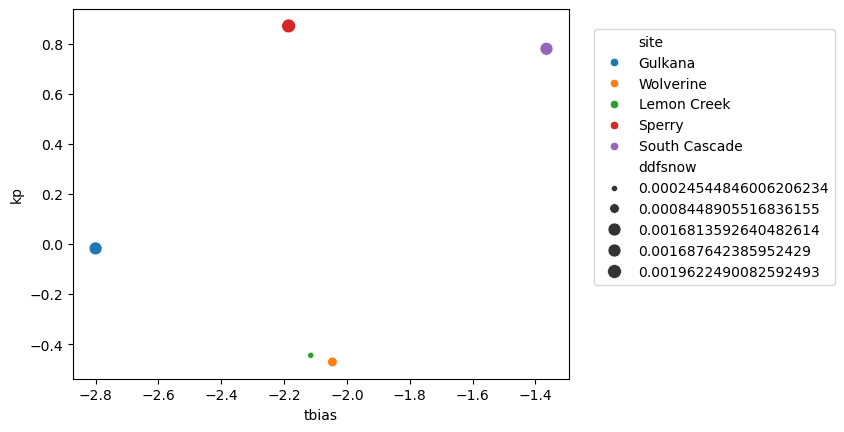

In [3]:
# Plot some results
df = df_results_full.copy()
df.reset_index(inplace=True)

df_orig = df[['site', 'parameter', 'Original']]
df_orig = df_orig.pivot(index=['site'], columns=['parameter'], values='Original').reset_index()
df_best = df[['site', 'parameter', 'Best']]
df_best = df_best.pivot(index=['site'], columns=['parameter'], values='Best').reset_index()
df_diff = df[['site', 'parameter', 'Original-Best']]
df_diff = df_diff.pivot(index=['site'], columns=['parameter'], values='Original-Best').reset_index()

fig, ax = plt.subplots()
a = sns.scatterplot(df_diff, x='tbias', y='kp', size='ddfsnow', hue='site', 
                sizes=(20,100), marker='o', 
                hue_order=['Gulkana', 'Wolverine', 'Lemon Creek', 'Sperry', 'South Cascade'], ax=ax)
sns.move_legend(a, loc='center right', bbox_to_anchor=[1.35, 0.5, 0.2, 0.2])